In [2]:
import pandas as pd
import numpy as np
import time
import pickle 
import torch

from sbi.utils import BoxUniform
from scipy.integrate import odeint
from sbi.utils import MultipleIndependent

import matplotlib.pyplot as plt

_ = np.random.seed(0)      

In [1]:
import platform
import sbi
import torch
import numpy as np

print(f"Python 버전: {platform.python_version()}")
print(f"sbi 버전: {sbi.__version__}")
print(f"PyTorch 버전: {torch.__version__}")
print(f"NumPy 버전: {np.__version__}")

Python 버전: 3.11.14
sbi 버전: 0.25.0
PyTorch 버전: 2.5.1+cu124
NumPy 버전: 2.3.4


In [3]:
with open('../NPE/data/M1_dataset.pkl', 'rb') as handle:
    sim_traj = pickle.load(handle)

with open('../NPE/data/M1_params.pkl', 'rb') as handle:
    sim_params = pickle.load(handle)

In [4]:
def poisson_noise(simulation):
    
    with_noise = np.random.poisson(np.maximum(simulation, 1e-6))

    return with_noise

In [5]:
traj_1k   = torch.tensor(poisson_noise(sim_traj[:1000].numpy()), dtype=torch.float32)
params_1k = sim_params[:1000]

traj_10k   = torch.tensor(poisson_noise(sim_traj[:10000].numpy()), dtype=torch.float32)
params_10k = sim_params[:10000]

traj_100k   = torch.tensor(poisson_noise(sim_traj[:100000].numpy()), dtype=torch.float32)
params_100k = sim_params[:100000]

In [6]:
with open('../sim_dataset.pkl', 'rb') as f:
    simulation_dataset = pickle.load(f)

In [7]:
from sbi.utils import BoxUniform
from scipy.integrate import odeint
from sbi.utils import MultipleIndependent

import torch
from torch.distributions import Uniform, Exponential, Cauchy

_ = torch.manual_seed(0)

device = "cuda:0" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

Using device: cpu


In [8]:
import torch.nn as nn
from sbi.inference import NPE
from sbi.neural_nets import posterior_nn

class LSTMembedding(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=128, output_dim=30, num_layers=1,bidirectional=True):
        super().__init__()

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, bidirectional=bidirectional, batch_first = True)
        self.fc = nn.Linear(hidden_dim * (2 if bidirectional else 1), output_dim)
        self.tanh = nn.Tanh()
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        if x.dim() == 2:
            x = x.unsqueeze(-1)
        lstm_out, _ = self.lstm(x)  
        last_hidden = lstm_out[:, -1, :]
        last_hidden = self.dropout(last_hidden)
        out = self.fc(last_hidden)   
        return out

In [9]:
embedding_net =LSTMembedding(input_dim=1, hidden_dim=128, output_dim=30).to(device)
embedding_net

LSTMembedding(
  (lstm): LSTM(1, 128, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=256, out_features=30, bias=True)
  (tanh): Tanh()
  (dropout): Dropout(p=0.1, inplace=False)
)

In [10]:
low  = torch.tensor([0.2, 0.1, 0.05])
high = torch.tensor([1.5, 0.5, 0.4])

prior = BoxUniform(low=low, high=high)

In [22]:
xs     = traj_1k
thetas = params_1k

In [25]:
neural_posterior = posterior_nn(model='maf', embedding_net=embedding_net)

In [26]:
inference = NPE(density_estimator=neural_posterior,device=device)

# training
start_time = time.time()
density_estimator_1k=inference.append_simulations(thetas, xs).train()
end_time = time.time() 
elapsed_time = end_time - start_time
print(f"time.time(): {elapsed_time:.4f} seconds")

 Neural network successfully converged after 328 epochs.time.time(): 321.4269 seconds


In [27]:
posterior_1k = inference.build_posterior(density_estimator_1k)

with open("./network/M1_1k_maf_posterior.pkl", "wb") as handle:
    pickle.dump(posterior_1k, handle)

with open("./network/M1_1k_maf_inference.pkl", "wb") as handle:
    pickle.dump(inference, handle)

/tmp/ipykernel_462155/2685334991.py:7: UserWarning: When the inference object is pickled, the behaviour of the loaded object changes in the following two ways: 1) `.train(..., retrain_from_scratch=True)` is not supported. 2) When the loaded object calls the `.train()` method, it generates a new tensorboard summary writer (instead of appending to the current one).
  pickle.dump(inference, handle)


In [28]:
import os
import glob

In [29]:
xlsx_files = sorted(glob.glob(os.path.join('../BayesianFit/output/','*.xlsx')))
posterior_ref = [pd.read_excel(file) for file in xlsx_files]

In [30]:
param_names=['beta','kappa','gamma']

100%|██████████| 10000/10000 [00:00<00:00, 172184.92it/s]


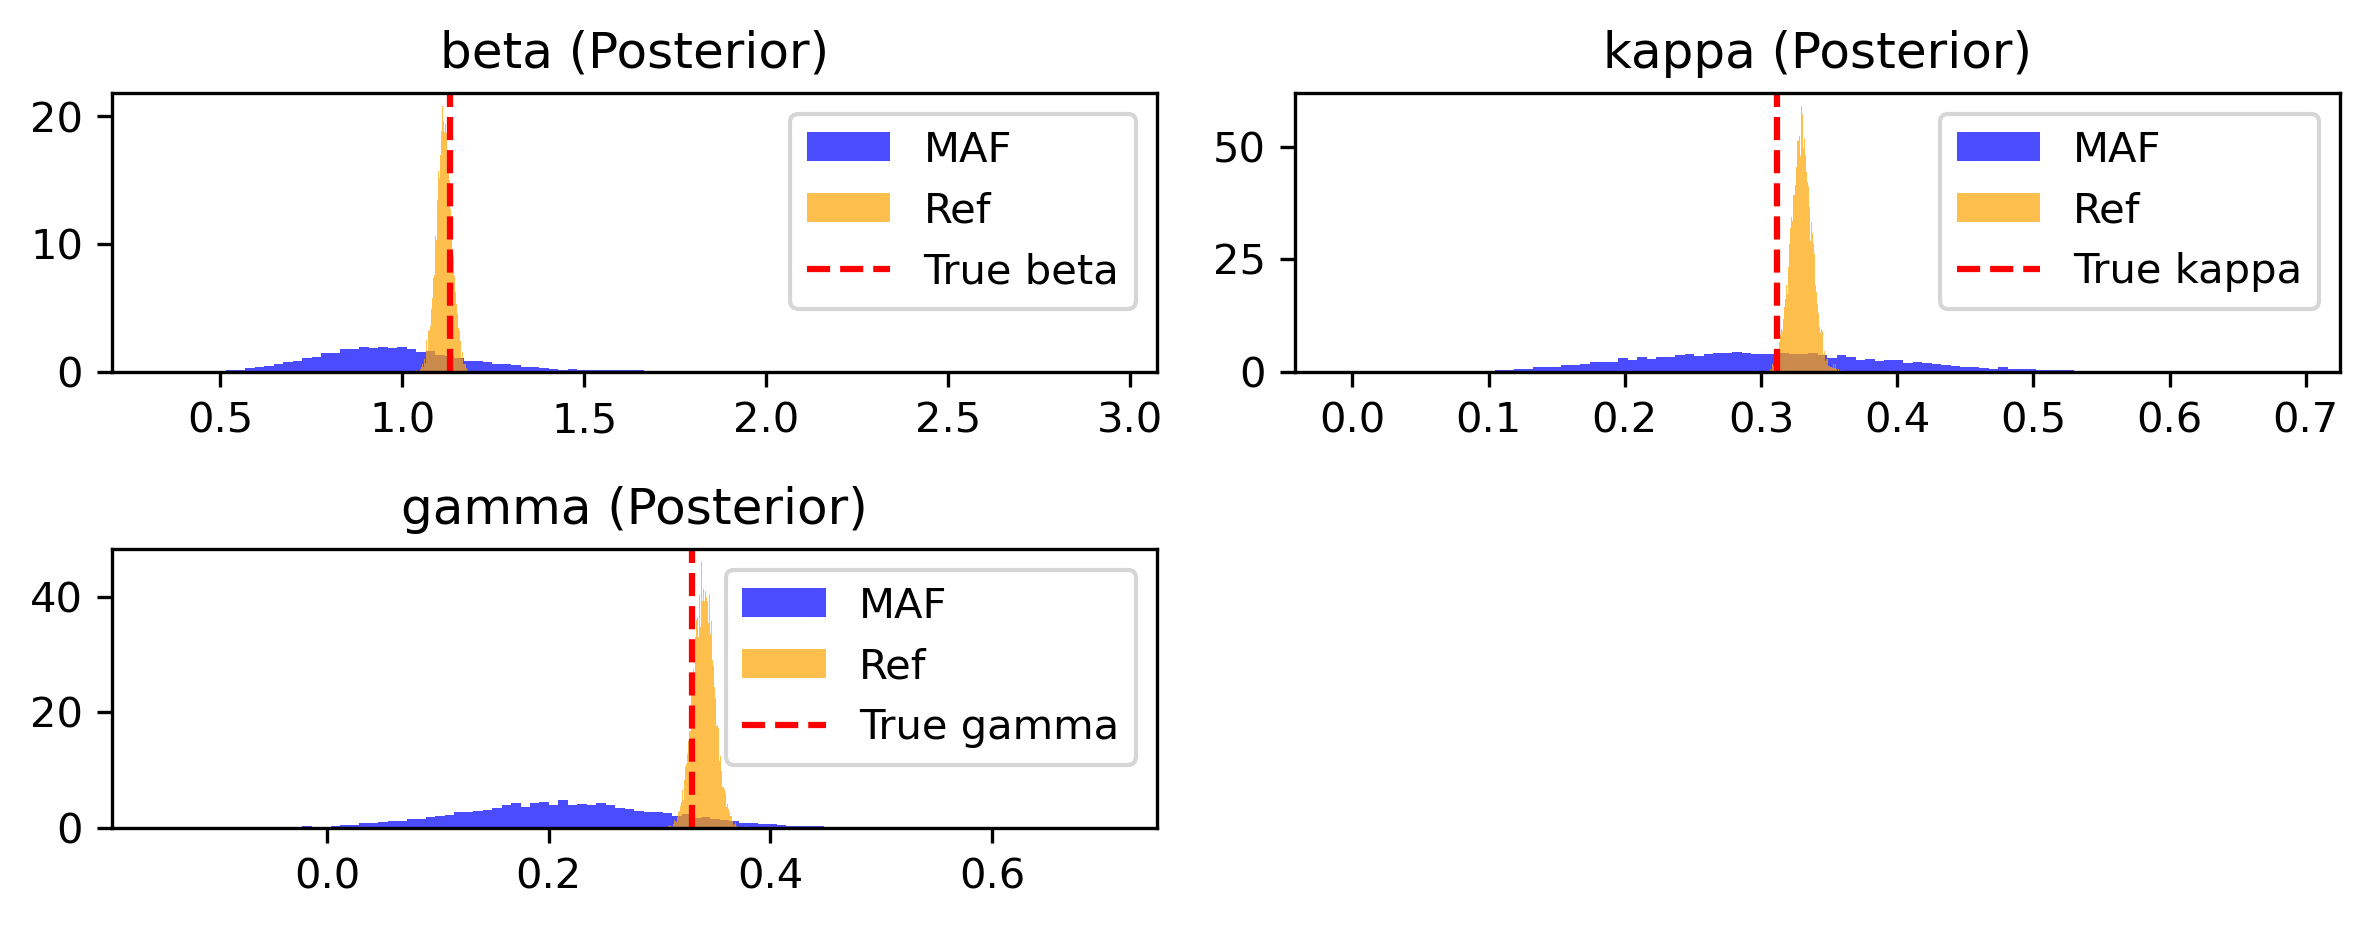

In [31]:
k = 1

x_obs = torch.as_tensor(simulation_dataset[k]['poisson'][:,0], dtype=torch.float32).to(device)

samples = posterior_1k.sample((10000,), x=x_obs)
df_1k=pd.DataFrame(samples, columns=['beta','kappa','gamma'])
ref_samples = posterior_ref[k]
npe_samples = df_1k
true_values = simulation_dataset[k]['params']

plt.figure(figsize=(8, 6),dpi=300)
for i in range(3):
    plt.subplot(4, 2, i + 1)
    plt.hist(npe_samples.iloc[:,i], bins=100, alpha=0.7, label="MAF", color='blue', density=True)
    plt.hist(ref_samples.iloc[:,i], bins=100, alpha=0.7, label="Ref", color='orange', density=True)
    plt.axvline(true_values[param_names[i]], color='red', linestyle='--', label=f"True {param_names[i]}")
    plt.title(f"{param_names[i]} (Posterior)")
    plt.legend()

plt.tight_layout()
plt.show()

In [32]:
from sbi.diagnostics import run_sbc, check_sbc
from sbi.analysis import sbc_rank_plot

In [33]:
# 1. SBC용 데이터 준비 (약 200세트 권장)
num_sbc_samples = 200
theta_sbc = sim_params[:200]
x_sbc = sim_traj[:200]

# 2. SBC 실행 (각 데이터마다 사후분포 샘플 1,000개씩 추출하여 랭크 계산)
ranks, dap_samples = run_sbc(
    theta_sbc, 
    x_sbc, 
    posterior_1k, 
    num_posterior_samples=1000
)

/home/gjang12/.conda/envs/sbi_env/lib/python3.11/site-packages/sbi/utils/diagnostics_utils.py:45: UserWarning: Capping max_sampling_batch_size from 10000 to 500 to avoid excessive memory usage.
  posterior_samples = posterior.sample_batched(
Calculating ranks for 200 SBC samples: 100%|██████████| 200/200 [00:00<00:00, 11505.43it/s]


In [34]:
check_stats = check_sbc(
    ranks, theta_sbc, dap_samples, num_posterior_samples=1000
)

In [35]:
print(
    f"""kolmogorov-smirnov p-values \n
    check_stats['ks_pvals'] = {check_stats['ks_pvals'].numpy()}"""
)

kolmogorov-smirnov p-values 

    check_stats['ks_pvals'] = [0.51580054 0.1561182  0.01897554]


In [36]:
print(
    f"c2st accuracies \ncheck_stats['c2st_ranks'] = {check_stats['c2st_ranks'].numpy()}"
)

c2st accuracies 
check_stats['c2st_ranks'] = [0.48   0.4975 0.5225]


In [37]:
print(f"- c2st accuracies check_stats['c2st_dap'] = {check_stats['c2st_dap'].numpy()}")

- c2st accuracies check_stats['c2st_dap'] = [0.5175 0.54   0.56  ]


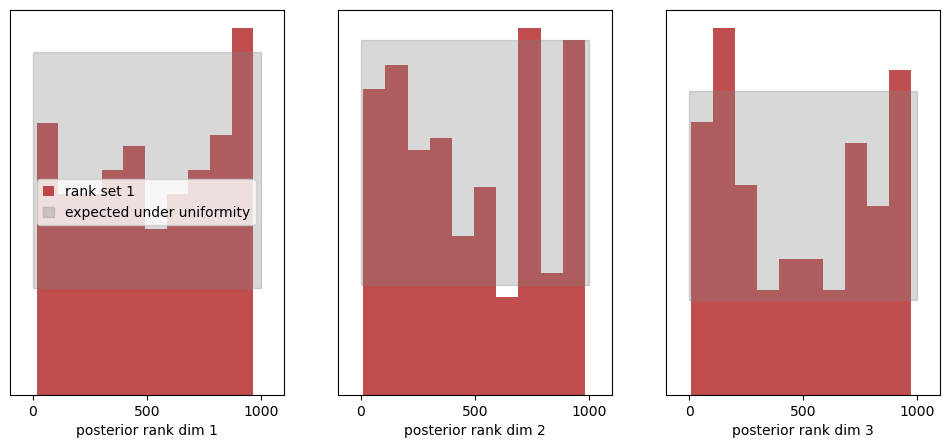

In [38]:
f, ax = sbc_rank_plot(
    ranks=ranks,
    num_posterior_samples=1000,
    plot_type="hist",
    num_bins=None,  # by passing None we use a heuristic for the number of bins.
)

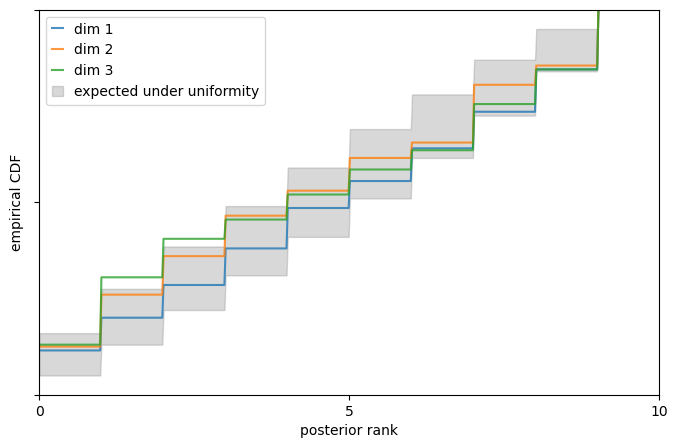

In [39]:
f, ax = sbc_rank_plot(ranks, 1_000, plot_type="cdf")

In [40]:
xs=traj_10k
thetas=params_10k

In [41]:
neural_posterior = posterior_nn(model='maf', embedding_net=embedding_net)

In [ ]:
inference = NPE(density_estimator=neural_posterior,device=device)

# training
start_time = time.time()
density_estimator_10k=inference.append_simulations(thetas, xs).train()
end_time = time.time() 
elapsed_time = end_time - start_time
print(f"time.time(): {elapsed_time:.4f} seconds")

 Training neural network. Epochs trained: 4

In [ ]:
posterior_10k = inference.build_posterior(density_estimator_10k)

with open("./network/M1_10k_maf_posterior.pkl", "wb") as handle:
    pickle.dump(posterior_10k, handle)

with open("./network/M1_10k_maf_inference.pkl", "wb") as handle:
    pickle.dump(inference, handle)

In [ ]:
k = 1

x_obs = torch.as_tensor(simulation_dataset[k]['poisson'][:,0], dtype=torch.float32).to(device)

samples = posterior_10k.sample((10000,), x=x_obs)
df_1k=pd.DataFrame(samples, columns=['beta','kappa','gamma'])
ref_samples = posterior_ref[k]
npe_samples = df_1k
true_values = simulation_dataset[k]['params']

plt.figure(figsize=(8, 6),dpi=300)
for i in range(3):
    plt.subplot(4, 2, i + 1)
    plt.hist(npe_samples.iloc[:,i], bins=100, alpha=0.7, label="MAF", color='blue', density=True)
    plt.hist(ref_samples.iloc[:,i], bins=100, alpha=0.7, label="Ref", color='orange', density=True)
    plt.axvline(true_values[param_names[i]], color='red', linestyle='--', label=f"True {param_names[i]}")
    plt.title(f"{param_names[i]} (Posterior)")
    plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# 1. SBC용 데이터 준비 (약 200세트 권장)
num_sbc_samples = 200
theta_sbc = sim_params[:200]
x_sbc = sim_traj[:200]

# 2. SBC 실행 (각 데이터마다 사후분포 샘플 1,000개씩 추출하여 랭크 계산)
ranks, dap_samples = run_sbc(
    theta_sbc, 
    x_sbc, 
    posterior_10k, 
    num_posterior_samples=1000
)

In [ ]:
check_stats = check_sbc(
    ranks, theta_sbc, dap_samples, num_posterior_samples=1000
)

In [ ]:
print(
    f"""kolmogorov-smirnov p-values \n
    check_stats['ks_pvals'] = {check_stats['ks_pvals'].numpy()}"""
)

In [ ]:
print(
    f"c2st accuracies \ncheck_stats['c2st_ranks'] = {check_stats['c2st_ranks'].numpy()}"
)

In [ ]:
print(f"- c2st accuracies check_stats['c2st_dap'] = {check_stats['c2st_dap'].numpy()}")

In [ ]:
f, ax = sbc_rank_plot(
    ranks=ranks,
    num_posterior_samples=1000,
    plot_type="hist",
    num_bins=None,  # by passing None we use a heuristic for the number of bins.
)

In [ ]:
f, ax = sbc_rank_plot(ranks, 1_000, plot_type="cdf")

In [ ]:
xs=traj_100k
thetas=params_100k

In [ ]:
neural_posterior = posterior_nn(model='maf', embedding_net=embedding_net)

In [ ]:
inference = NPE(density_estimator=neural_posterior,device=device)

# training
start_time = time.time()
density_estimator_100k=inference.append_simulations(thetas, xs_norm).train()
end_time = time.time() 
elapsed_time = end_time - start_time
print(f"time.time(): {elapsed_time:.4f} seconds")

In [ ]:
posterior_100k = inference.build_posterior(density_estimator_100k)

with open("./network/M1_100k_maf_posterior.pkl", "wb") as handle:
    pickle.dump(posterior_100k, handle)

with open("./network/M1_100k_maf_inference.pkl", "wb") as handle:
    pickle.dump(inference, handle)

In [ ]:
k = 1

x_obs = torch.as_tensor(simulation_dataset[k]['poisson'][:,0], dtype=torch.float32).to(device)

samples = posterior_100k.sample((10000,), x=x_obs)
df_1k=pd.DataFrame(samples, columns=['beta','kappa','gamma'])
ref_samples = posterior_ref[k]
npe_samples = df_1k
true_values = simulation_dataset[k]['params']

plt.figure(figsize=(8, 6),dpi=300)
for i in range(3):
    plt.subplot(4, 2, i + 1)
    plt.hist(npe_samples.iloc[:,i], bins=100, alpha=0.7, label="MAF", color='blue', density=True)
    plt.hist(ref_samples.iloc[:,i], bins=100, alpha=0.7, label="Ref", color='orange', density=True)
    plt.axvline(true_values[param_names[i]], color='red', linestyle='--', label=f"True {param_names[i]}")
    plt.title(f"{param_names[i]} (Posterior)")
    plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# 1. SBC용 데이터 준비 (약 200세트 권장)
num_sbc_samples = 200
theta_sbc = sim_params[:200]
x_sbc = sim_traj[:200]

# 2. SBC 실행 (각 데이터마다 사후분포 샘플 1,000개씩 추출하여 랭크 계산)
ranks, dap_samples = run_sbc(
    theta_sbc, 
    x_sbc, 
    posterior_100k, 
    num_posterior_samples=1000
)

In [ ]:
check_stats = check_sbc(
    ranks, theta_sbc, dap_samples, num_posterior_samples=1000
)

In [ ]:
print(
    f"""kolmogorov-smirnov p-values \n
    check_stats['ks_pvals'] = {check_stats['ks_pvals'].numpy()}"""
)

In [ ]:
print(
    f"c2st accuracies \ncheck_stats['c2st_ranks'] = {check_stats['c2st_ranks'].numpy()}"
)

In [ ]:
print(f"- c2st accuracies check_stats['c2st_dap'] = {check_stats['c2st_dap'].numpy()}")

In [ ]:
f, ax = sbc_rank_plot(
    ranks=ranks,
    num_posterior_samples=1000,
    plot_type="hist",
    num_bins=None,  # by passing None we use a heuristic for the number of bins.
)

In [ ]:
f, ax = sbc_rank_plot(ranks, 1_000, plot_type="cdf")